In [1]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import pylab as plt

seed = 42

sizes = [18, 10]
p_intra = 0.1
p_inter = 0.9

graph = nx.stochastic_block_model(
    sizes=sizes, p=[[p_intra, p_inter], [p_inter, p_intra]], seed=seed
)

Restricted license - for non-production use only - expires 2026-11-23


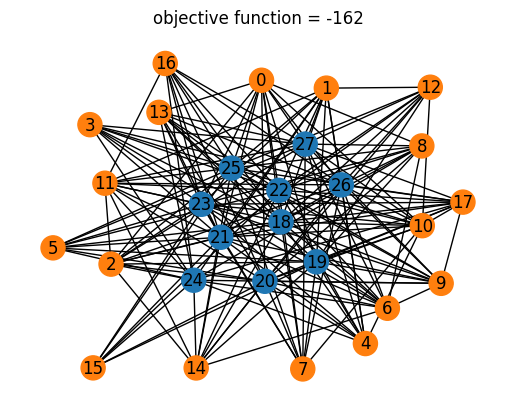

In [2]:
from gurobi import MaxCutGurobi

grb = MaxCutGurobi()
grb.build_model(graph=graph)
solution, objval = grb.run_model(verbose=False)

fig, ax = plt.subplots()
grb.show_result(sol=solution, obj=objval, ax=ax)

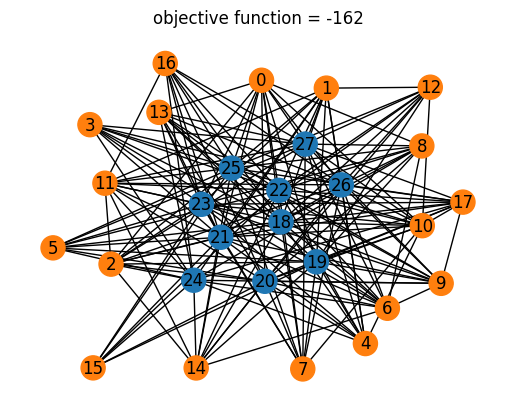

In [3]:
from pce import MaxCutPCE

num_qubits = 8
num_layers = 4
k_body_corr = 2


def ansatz(params):
    for l in range(num_layers):
        thetas = params[l]
        for w in range(num_qubits):
            qml.RY(phi=thetas[w], wires=w)
        for w in range(num_qubits - 1):
            qml.CNOT(wires=[w, w + 1])


dev = qml.device("default.qubit")
opt = qml.optimize.AdamOptimizer(stepsize=0.1)
alpha = num_qubits ** (k_body_corr / 2)
pce = MaxCutPCE(device=dev, optimizer=opt, ansatz=ansatz, alpha=alpha)

pauli_ops = MaxCutPCE.get_pauli_ops(n=num_qubits, k=k_body_corr, bases=["X"])
pce.build_model(graph=graph, num_qubits=num_qubits, pauli_ops=pauli_ops)

np.random.seed(seed)
params = np.random.uniform(size=(num_layers, num_qubits), requires_grad=True)
solution, objval = pce.run_model(params=params, iters=200)

fig, ax = plt.subplots()
pce.show_result(sol=solution, obj=objval, ax=ax)